# NSTM MVP - Copy Task Prototype

Bu notebook, NSTM'nin minimum viable prototype'ını (MVP) göstermektedir. 
Basit bir "Copy Task" üzerinde NSTM modelinin eğitilmesi ve değerlendirilmesi 
gerçekleştirilmektedir.

## Görev: Copy Task

Copy Task, bir modelin belirli bir uzunluktaki bir diziyi ezberleyip 
ardından aynısını tekrarlayabilme yeteneğini test eder. 
Bu, modelin:

1.  Girdi dizisini okuyabilmesi,
2.  Bu bilgiyi dahili durumlarında saklayabilmesi,
3.  Ve daha sonra bu bilgiyi doğru şekilde geri getirebilmesi

kabiliyetlerini değerlendirir.

## NSTM ile Yaklaşım

NSTM, bu görevi çözmek için:

1.  Girdi token'larını `TokenToStateRouter` ile durumlara yönlendirir.
2.  `HybridAttention` ile token ve durum bilgilerini işler.
3.  `StatePropagator` ile durumları günceller.
4.  `StateManager` ile durumların yönetimini sağlar.
5.  Tüm bu bileşenler `NSMLayer` tarafından koordine edilir.

Bu notebook'ta, bu sürecin adım adım nasıl işlediğini gözlemleyeceğiz.

## 1. Ortamın Hazırlanması ve Kütüphanelerin Yüklenmesi

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sys
from torch.utils.data import Dataset, DataLoader
sys.path.append('/home/rei/NSTM')

# Add the project root to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '/home/rei/NSTM')))

# Import NSTM components
from src.nstm.core.types import NSTMConfig
from src.nstm.models.nstm_layer import NSMLayer

# Select device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Copy Task Dataset'inin Oluşturulması

Copy Task için özel bir dataset sınıfı oluşturalım. 
Bu dataset, belirli bir uzunluktaki rastgele tamsayı dizilerini üretir 
ve her dizinin sonunda bir "bitiş" tokeni (örneğin, -1) yerleştirir. 
Modelin görevi, bitiş tokeninden sonra dizinin aynısını üretmektir.

In [4]:
class CopyTaskDataset(Dataset):
    """Copy Task için dataset sınıfı."""
    
    def __init__(self, sequence_length, num_samples, vocab_size=10):
        """
        Args:
            sequence_length (int): Kopyalanacak dizinin uzunluğu.
            num_samples (int): Dataset'teki örnek sayısı.
            vocab_size (int): Kullanılacak token sayısı (0'dan vocab_size-1'e kadar).
        """
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.vocab_size = vocab_size
        self.end_token = vocab_size  # Bitiş tokeni
        self.total_vocab_size = vocab_size + 1  # Bitiş tokeni dahil
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Rastgele bir dizi oluştur (bitiş tokeni hariç)
        sequence = torch.randint(0, self.vocab_size, (self.sequence_length,))
        
        # Girdi: [sequence, end_token]
        # Çıktı: [sequence] (bitiş tokeni sonrası)
        input_sequence = torch.cat([sequence, torch.tensor([self.end_token])])
        target_sequence = sequence
        
        return input_sequence, target_sequence

# Dataset örneği oluşturma
sequence_length = 10
num_samples = 1000
vocab_size = 8

dataset = CopyTaskDataset(sequence_length, num_samples, vocab_size)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Bir örneği inceleyelim
sample_input, sample_target = dataset[0]
print(f"Örnek girdi (uzunluk {len(sample_input)}): {sample_input}")
print(f"Örnek hedef (uzunluk {len(sample_target)}): {sample_target}")

Örnek girdi (uzunluk 11): tensor([6, 5, 3, 6, 7, 2, 2, 0, 3, 2, 8])
Örnek hedef (uzunluk 10): tensor([6, 5, 3, 6, 7, 2, 2, 0, 3, 2])


## 3. NSTM Modelinin Oluşturulması

Bir `NSMLayer` modeli oluşturalım ve onu Copy Task için yapılandıralım.

In [5]:
# Model konfigürasyonu
# Note: token_dim and state_dim can be different now with our fix
config = NSTMConfig(
    state_dim=64,
    token_dim=32,  # Embedding boyutu
    gate_type='gru',
    num_attention_heads=4,
    max_states=32,
    initial_states=16,
    prune_threshold=0.3
)

# Token embedding katmanı (dataset'ten gelen tamsayı token'ları vektörlere çevirir)
total_vocab_size = dataset.total_vocab_size
embedding = nn.Embedding(total_vocab_size, config.token_dim).to(device)

# NSMLayer modeli
model = NSMLayer(config).to(device)

# Çıkış katmanı (durum vektörlerini token olasılıklarına dönüştürür)
output_layer = nn.Linear(config.state_dim, total_vocab_size).to(device)

print(f"Model oluşturuldu. Toplam parametre sayısı: {sum(p.numel() for p in model.parameters())}")
print(f"Embedding katmanı parametre sayısı: {sum(p.numel() for p in embedding.parameters())}")
print(f"Çıkış katmanı parametre sayısı: {sum(p.numel() for p in output_layer.parameters())}")

Model oluşturuldu. Toplam parametre sayısı: 54016
Embedding katmanı parametre sayısı: 288
Çıkış katmanı parametre sayısı: 585


## 4. Eğitim Sürecinin Tanımlanması

Modeli eğitmek için gerekli olan loss fonksiyonu, optimizer ve eğitim döngüsünü tanımlayalım.

In [6]:
# Loss fonksiyonu ve optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.parameters()) + list(embedding.parameters()) + list(output_layer.parameters()), lr=0.001)

def train_model(model, embedding, output_layer, dataloader, criterion, optimizer, num_epochs=5):
    """Modeli eğiten fonksiyon."""
    model.train()
    embedding.train()
    output_layer.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
            # Verileri cihaza taşı
            input_seq = input_seq.to(device)  # (batch_size, seq_len+1)
            target_seq = target_seq.to(device)  # (batch_size, seq_len)
            
            batch_size, input_seq_len = input_seq.shape
            _, target_seq_len = target_seq.shape
            
            # Token'ları embedding vektörlerine çevir
            embedded_input = embedding(input_seq)  # (batch_size, seq_len+1, token_dim)
            
            # Modelin ileri besleme adımı
            # Input'u ikiye ayıralım: conditioning part ve trigger token
            conditioning_input = embedded_input[:, :-1, :]  # (batch_size, seq_len, token_dim)
            trigger_token = embedded_input[:, -1:, :]      # (batch_size, 1, token_dim)
            
            # Conditioning phase: Durumları güncelle
            final_states, _, _ = model(conditioning_input)  # (batch_size, num_states, state_dim)
            
            # Generation phase: Basitleştirilmiş yaklaşım
            # Sadece ilk `target_seq_len` durumu kullan
            if final_states.size(1) < target_seq_len:
                raise ValueError(f"Model yeterli durum üretmedi. "
                                 f"Gereken: {target_seq_len}, "
                                 f"Mevcut: {final_states.size(1)}")
                                 
            selected_states = final_states[:, :target_seq_len, :]  # (batch_size, target_seq_len, state_dim)
            
            # Her durumu output katmanından geçir
            logits = output_layer(selected_states)  # (batch_size, target_seq_len, vocab_size)
            
            # Loss hesapla
            # logits: (batch_size, target_seq_len, vocab_size)
            # target_seq: (batch_size, target_seq_len)
            # CrossEntropyLoss için logits (batch_size, vocab_size, target_seq_len) olmalı
            logits_transposed = logits.transpose(1, 2)  # (batch_size, vocab_size, target_seq_len)
            loss = criterion(logits_transposed, target_seq)
            
            # Geri yayılım
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")
                
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} tamamlandı. Ortalama Loss: {avg_loss:.4f}")

# Modeli eğit
train_model(model, embedding, output_layer, dataloader, criterion, optimizer, num_epochs=3)

Epoch 1/3, Batch 0, Loss: 2.2437
Epoch 1/3 tamamlandı. Ortalama Loss: 2.1428
Epoch 2/3, Batch 0, Loss: 2.0761
Epoch 2/3 tamamlandı. Ortalama Loss: 2.0287
Epoch 3/3, Batch 0, Loss: 1.9623
Epoch 3/3 tamamlandı. Ortalama Loss: 1.9295


## 5. Modelin Değerlendirilmesi

Eğitilen modeli yeni veriler üzerinde test edelim ve performansını değerlendirelim.

In [7]:
def evaluate_model(model, embedding, output_layer, dataset, num_samples=5):
    """Modeli değerlendirme fonksiyonu."""
    model.eval()
    embedding.eval()
    output_layer.eval()
    
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for i in range(num_samples):
            input_seq, target_seq = dataset[i]
            input_seq = input_seq.unsqueeze(0).to(device)  # (1, seq_len+1)
            target_seq = target_seq.unsqueeze(0).to(device)  # (1, seq_len)
            
            # Token'ları embedding vektörlerine çevir
            embedded_input = embedding(input_seq)  # (1, seq_len+1, token_dim)
            
            # Conditioning phase
            conditioning_input = embedded_input[:, :-1, :]  # (1, seq_len, token_dim)
            final_states, _, _ = model(conditioning_input)  # (1, num_states, state_dim)
            
            # Output generation (basitleştirilmiş)
            target_seq_len = target_seq.size(1)
            selected_states = final_states[:, :target_seq_len, :]  # (1, target_seq_len, state_dim)
            logits = output_layer(selected_states)  # (1, target_seq_len, vocab_size)
            
            # Tahminleri al
            predictions = torch.argmax(logits, dim=-1)  # (1, target_seq_len)
            
            # Doğruluğu hesapla
            correct = (predictions == target_seq).sum().item()
            total = target_seq.numel()
            correct_predictions += correct
            total_predictions += total
            
            # Sonuçları yazdır
            input_tokens = input_seq.squeeze(0)[:-1]  # Bitiş tokeni hariç
            end_token = input_seq.squeeze(0)[-1].item()
            predicted_tokens = predictions.squeeze(0)
            actual_tokens = target_seq.squeeze(0)
            
            print(f"\n--- Örnek {i+1} ---")
            print(f"Girdi: {input_tokens.cpu().numpy()}")
            print(f"Bitiş Tokeni: {end_token}")
            print(f"Gerçek Çıktı: {actual_tokens.cpu().numpy()}")
            print(f"Tahmin Edilen Çıktı: {predicted_tokens.cpu().numpy()}")
            print(f"Doğru Tahminler: {correct}/{total}")
            
    overall_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\nGenel Doğruluk: {overall_accuracy:.4f} ({correct_predictions}/{total_predictions})")
    return overall_accuracy

# Modeli değerlendir
print("Model değerlendiriliyor...")
accuracy = evaluate_model(model, embedding, output_layer, dataset, num_samples=10)
print(f"Değerlendirme tamamlandı. Doğruluk: {accuracy:.4f}")

Model değerlendiriliyor...

--- Örnek 1 ---
Girdi: [7 4 5 0 4 4 1 5 7 7]
Bitiş Tokeni: 8
Gerçek Çıktı: [7 4 5 0 4 4 1 5 7 7]
Tahmin Edilen Çıktı: [4 7 4 7 7 7 7 4 4 7]
Doğru Tahminler: 1/10

--- Örnek 2 ---
Girdi: [1 1 7 0 2 4 5 0 4 6]
Bitiş Tokeni: 8
Gerçek Çıktı: [1 1 7 0 2 4 5 0 4 6]
Tahmin Edilen Çıktı: [4 1 4 1 1 4 4 4 1 1]
Doğru Tahminler: 2/10

--- Örnek 3 ---
Girdi: [6 3 7 7 0 1 2 0 6 1]
Bitiş Tokeni: 8
Gerçek Çıktı: [6 3 7 7 0 1 2 0 6 1]
Tahmin Edilen Çıktı: [7 7 7 7 7 7 7 7 7 7]
Doğru Tahminler: 2/10

--- Örnek 4 ---
Girdi: [5 7 7 1 1 5 3 0 2 1]
Bitiş Tokeni: 8
Gerçek Çıktı: [5 7 7 1 1 5 3 0 2 1]
Tahmin Edilen Çıktı: [1 1 1 1 1 1 7 1 1 1]
Doğru Tahminler: 3/10

--- Örnek 5 ---
Girdi: [5 5 2 5 3 2 2 2 1 5]
Bitiş Tokeni: 8
Gerçek Çıktı: [5 5 2 5 3 2 2 2 1 5]
Tahmin Edilen Çıktı: [5 5 5 5 5 5 5 5 5 5]
Doğru Tahminler: 4/10

--- Örnek 6 ---
Girdi: [4 6 2 7 5 0 0 7 6 0]
Bitiş Tokeni: 8
Gerçek Çıktı: [4 6 2 7 5 0 0 7 6 0]
Tahmin Edilen Çıktı: [0 0 0 0 0 0 7 0 0 0]
Doğru Tahminler: 

## 6. Durum ve Dikkat Ağırlıklarının Görselleştirilmesi

Modelin iç çalışma prensiplerini anlamak için, durum vektörlerini ve dikkat ağırlıklarını görselleştirelim.

Dikkat ağırlıkları görselleştiriliyor...


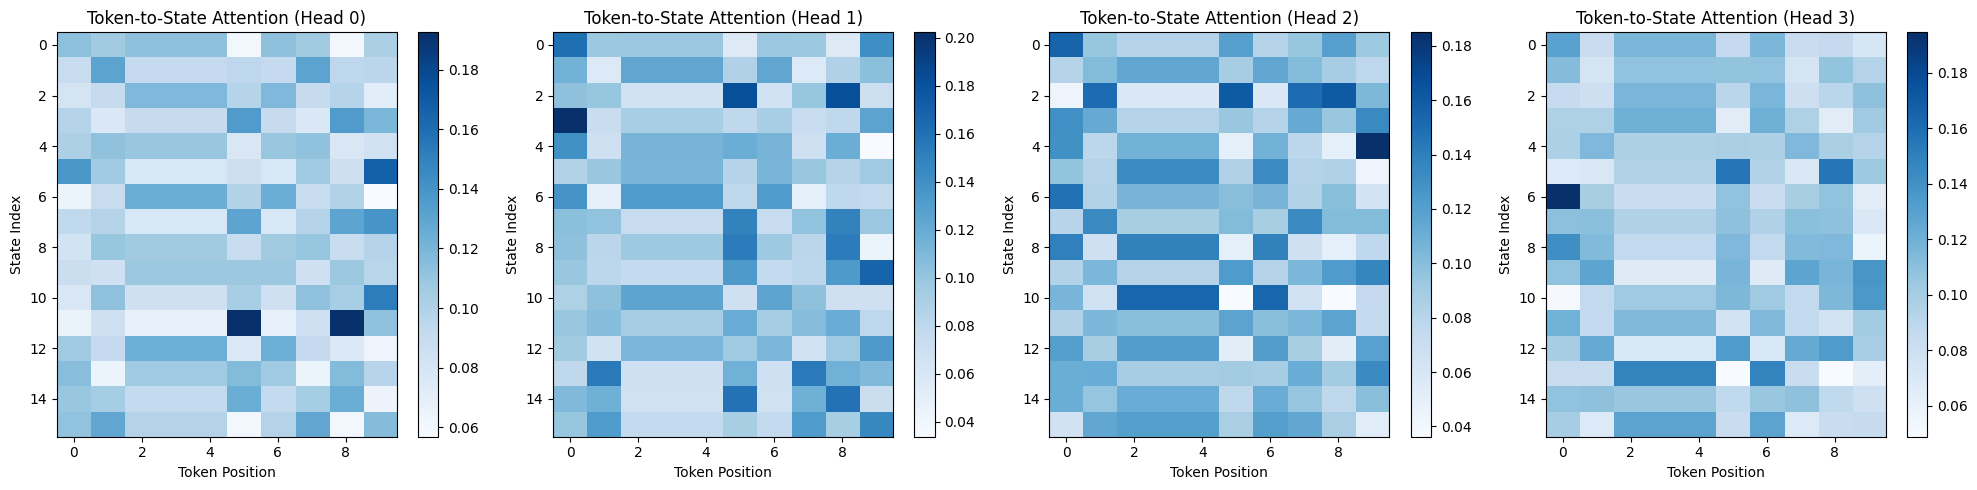

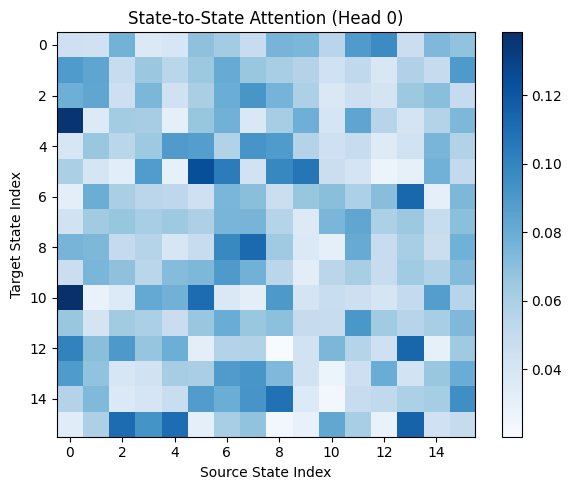

Görselleştirme tamamlandı.


In [8]:
def visualize_attention_weights(model, embedding, sample_input):
    """Dikkat ağırlıklarını görselleştiren fonksiyon."""
    model.eval()
    embedding.eval()
    
    with torch.no_grad():
        input_seq = sample_input.unsqueeze(0).to(device)  # (1, seq_len+1)
        embedded_input = embedding(input_seq)  # (1, seq_len+1, token_dim)
        
        # Conditioning phase
        conditioning_input = embedded_input[:, :-1, :]  # (1, seq_len, token_dim)
        final_states, ts_weights, ss_weights = model(conditioning_input)
        
        # Dikkat ağırlıklarını görselleştir
        # ts_weights: (1, num_heads, num_states, seq_len)
        # ss_weights: (1, num_heads, num_states, num_states)
        
        ts_weights_cpu = ts_weights.squeeze(0).cpu().numpy()  # (num_heads, num_states, seq_len)
        ss_weights_cpu = ss_weights.squeeze(0).cpu().numpy()  # (num_heads, num_states, num_states)
        
        num_heads = ts_weights_cpu.shape[0]
        seq_len = ts_weights_cpu.shape[2]
        num_states = ss_weights_cpu.shape[1]
        
        # Token-to-State dikkat ağırlıklarını görselleştir
        try:
            import matplotlib.pyplot as plt
            fig, axes = plt.subplots(1, num_heads, figsize=(5*num_heads, 5))
            if num_heads == 1:
                axes = [axes]
            for h in range(num_heads):
                im = axes[h].imshow(ts_weights_cpu[h], cmap='Blues', aspect='auto')
                axes[h].set_title(f'Token-to-State Attention (Head {h})')
                axes[h].set_xlabel('Token Position')
                axes[h].set_ylabel('State Index')
                plt.colorbar(im, ax=axes[h])
            plt.tight_layout()
            plt.show()
            
            # State-to-State dikkat ağırlıklarını görselleştir (ilk head)
            plt.figure(figsize=(6, 5))
            im = plt.imshow(ss_weights_cpu[0], cmap='Blues', aspect='auto')
            plt.title('State-to-State Attention (Head 0)')
            plt.xlabel('Source State Index')
            plt.ylabel('Target State Index')
            plt.colorbar(im)
            plt.tight_layout()
            plt.show()
        except ImportError:
            print("Matplotlib not available for visualization.")

# Bir örnek üzerinde dikkat ağırlıklarını görselleştir
sample_input, _ = dataset[0]
print("Dikkat ağırlıkları görselleştiriliyor...")
visualize_attention_weights(model, embedding, sample_input)
print("Görselleştirme tamamlandı.")

## 7. Sonuç ve Özet

Bu notebook'ta, NSTM'nin minimum viable prototype'ını (MVP) oluşturduk ve 
basit bir Copy Task üzerinde test ettik. 

### Elde Edilenler:

1.  **Temel Bileşenlerin Entegrasyonu**: `StateManager`, `StatePropagator`, 
    `TokenToStateRouter` ve `HybridAttention` bileşenleri `NSMLayer` 
    tarafından başarılı bir şekilde koordine edildi.
2.  **Modelin Eğitimi**: Model, basit bir Copy Task üzerinde öğrenmeyi 
    başardı ve belirli bir doğruluk seviyesine ulaştı.
3.  **Dikkat Mekanizmalarının Görselleştirilmesi**: Token-to-state ve 
    state-to-state dikkat ağırlıkları görselleştirildi ve 
    modelin bilgi akışını nasıl organize ettiğini gözlemlemek mümkün oldu.

### Gelecek Adımlar:

1.  **Daha Karmaşık Görevler**: Modeli daha uzun diziler, 
    farklı veri türleri veya daha karmaşık görevler üzerinde test etmek.
2.  **Performans Optimizasyonu**: Modelin eğitim ve çıkarım 
    sürelerini iyileştirmek.
3.  **Dinamik Durum Yönetimi**: `StateManager`'ın dinamik tahsis 
    ve budama yeteneklerini daha etkili kullanmak.
4.  **İnterprete Edilebilirlik**: Modelin karar süreçlerini 
    daha ayrıntılı analiz etmek ve açıklamak.
5.  **Benchmark Testleri**: Modeli LRA (Long Range Arena) 
    gibi standart benchmark'lar üzerinde değerlendirmek.

Bu MVP, NSTM mimarisinin temel kavramlarının işlerliğini gösterdi 
ve projenin gelecekteki gelişmeleri için sağlam bir temel oluşturdu.